In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import struct

In [109]:
def load_mnist(path, kind='train'):
    labels_path = '{}-labels-idx1-ubyte'.format(kind)
    images_path = '{}-images-idx3-ubyte'.format(kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784) # 784=28x28 pixel images
    return images, labels

In [110]:
X_train, y_train = load_mnist('.', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

Rows: 60000, columns: 784


In [111]:
X_test, y_test = load_mnist('mnist', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


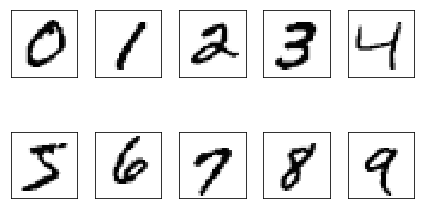

In [112]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28) # reshape back to 28x28 shape
    ax[i].imshow(img, cmap='Greys', interpolation='nearest') # see: https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.imshow.html
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

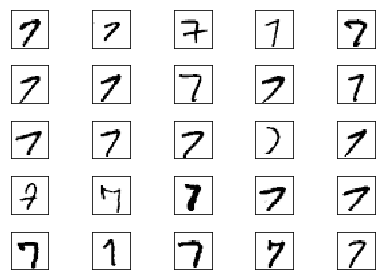

In [113]:
fig, ax = plt.subplots(
  nrows=5,
  ncols=5,
  sharex=True,
  sharey=True
)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [123]:
# Multi-layer perceptron
from scipy.special import expit # expit=sigmoid function
import sys
from sklearn.preprocessing import OneHotEncoder

class NeuralNetMLP(object):
    def __init__(self, n_output, n_features, n_hidden=30,
                 l1=0.0, l2=0.0, epochs=500, eta=0.001,
                 alpha=0.0, decrease_const=0.0, shuffle=True,
                 minibatches=1, random_state=None):

        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

    # return k arrays, where k = n_groups; each array represents y[y==i]
    def _encode_labels(self, y, k):
        ohe = OneHotEncoder(categorical_features=[0]) 
        return ohe.fit_transform(y.reshape(-1,1)).toarray().T

    # w1: n_hidden * n_feature + 1 (bias unit) matrix of random floats (with uniform distribution)
    # w2: n_output * n_hidden + 1 (bias unit) matrix of random floats
    def _initialize_weights(self):
        w1 = self._random_weights(self.n_features, self.n_hidden)
        w2 = self._random_weights(self.n_hidden, self.n_output)
        return w1, w2
    
    def _random_weights(self, n_in, n_out):
        w = np.random.uniform(-1.0, 1.0, size=n_out*(n_in + 1))
        return w.reshape(n_out, n_in + 1)

    def _sigmoid_gradient(self, z):
        return expit(z) * (1 - expit(z)) # expit=sigmoid function

    def _add_bias_unit(self, X, how='column'):
        if how == 'column':
            ones = np.ones(X.shape[0]).reshape(-1,1)
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones(X.shape[1])
            X_new = np.vstack((ones, X))
        return X_new

    def _feedforward(self, X, w1, w2):
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = expit(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = expit(z3)
        return a1, z2, a2, z3, a3

    # L2 regulatization - sum of squares of weights
    # note: bias unit/constant does not need to be regularized, ergo w[:, 1:]
    def _L2_reg(self, lambda_, w1, w2):
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2) + np.sum(w2[:, 1:] ** 2))

    # L1 regulatization - sum of abs value of weights
    # note: bias unit/constant does not need to be regularized,
    def _L1_reg(self, lambda_, w1, w2):
        return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum() + np.abs(w2[:, 1:]).sum())

    # cost = - sum of [ y*log(a) (term1) + (1-y)*log(1-a) (term2) ]
    # y_enc is y passed to encode_labels
    def _get_cost(self, y_enc, output, w1, w2):
        term1 = y_enc * (np.log(output))
        term2 = (1 - y_enc) * np.log(1 - output)
        cost = -np.sum(term1 + term2)
        L1_term = self._L1_reg(self.l1, w1, w2) # L1 regulatization
        L2_term = self._L2_reg(self.l2, w1, w2) # L2 regulatization
        cost = cost + L1_term + L2_term
        return cost

    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        # backpropagation
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)

        # regularize
        grad1[:, 1:] += (w1[:, 1:] * (self.l1 + self.l2))
        grad2[:, 1:] += (w2[:, 1:] * (self.l1 + self.l2))

        return grad1, grad2

    def predict(self, X):
        if len(X.shape) != 2:
            raise AttributeError('X must be a [n_samples, n_features] array.\n'
                                 'Use X[:,None] for 1-feature classification,'
                                 '\nor X[[i]] for 1-sample classification')

        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False):
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)

        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in mini:

                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx], self.w1, self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx],
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)
                self.cost_.append(cost)

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
                                                  a3=a3, z2=z2,
                                                  y_enc=y_enc[:, idx],
                                                  w1=self.w1,
                                                  w2=self.w2)

                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2

        return self

In [154]:
nn = NeuralNetMLP(
  n_output=10,
  n_features=X_train.shape[1],
  n_hidden=50,
  l2=0.1,
  l1=0.0,
  epochs=1000,
  eta=0.001,
  alpha=0.001,
  decrease_const=0.00001,
  shuffle=True,
  minibatches=50,
  random_state=1
)
nn.fit(X_train, y_train, print_progress=True)

Epoch: 42/1000

KeyboardInterrupt: 

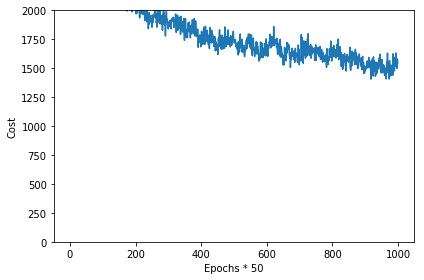

In [153]:
plt.plot(range(len(nn.cost_)) , nn.cost_)
plt.ylim([0, 2000])
plt.ylabel('Cost')
plt.xlabel('Epochs * 50')
plt.tight_layout()
plt.show()

In [137]:
y_train_pred = nn.predict(X_train)
acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]
print('Training accuracy: %.2f%%' % (acc * 100))

Training accuracy: 87.81%


In [138]:
y_test_pred = nn.predict(X_test)
acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]
print('Training accuracy: %.2f%%' % (acc * 100))

Training accuracy: 87.88%
